In [2]:
import numpy as np
import matplotlib.pyplot as plt
import spotipy
from spotipy.oauth2 import SpotifyOAuth

In [3]:
# the 4 downtempo playlist ids
APRESLIST_ID = "1Gbl0gYulJ5oXzCZWyR1Hr"
SERIOUSLY_ID = "12b7lLOydJ1rzgcp2H0uye"
ZZZ_ID = "0pWvAfI5sFdQ2DzaXXGLJ9"
SHEEP_ID = "5OJyVfvGLNO3o8rj0cHdOC"

We start by grabbing all the tracks for each playlist in batches of 100 and building up a feature matrix for each playlist using the audio features for each batch of tracks returned by the Spotify API. The relevant available features for a track are acousticness, danceability, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, and valence. It's unlikely all of these features will be helpful when building a model for each playlist but we'll go ahead and fetch all of them anyway.

In [4]:
# initialize the client with just the scope we need here (reading playlist data)
scope = 'playlist-read-private'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

In [7]:
features = [
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "key",
    "liveness",
    "loudness",
    "mode",
    "speechiness",
    "tempo",
    "valence"
]

In [26]:
# grab all the tracks from the all playlists and return their audio features

def parse_audio_features(audio_features_list: list[dict]) -> list[list[float]]:
    audio_features: list[list[float]] = []
    for af in audio_features_list:
        feature_vec = [af[feat] for feat in features]
        audio_features.append(feature_vec)
    return audio_features

def get_track_ids(tracks: dict) -> list[str]:
    return [t["track"]["id"] for t in tracks["items"] if t["track"]["id"]]

def get_playlist_track_data(playlist_id: str) -> tuple[list,list]:
    track_ids: list[str] = []
    track_features: list[list[float]] = []
    track_results = sp.playlist(playlist_id, fields="tracks,next")
    tracks = track_results["tracks"]
    batch_track_ids = get_track_ids(tracks)
    track_ids.extend(batch_track_ids)
    audio_feature_results = sp.audio_features(batch_track_ids)
    batch_audio_features = parse_audio_features(audio_feature_results)
    track_features.extend(batch_audio_features)
    while tracks["next"]:
        tracks = sp.next(tracks)
        batch_track_ids = get_track_ids(tracks)
        track_ids.extend(batch_track_ids)
        audio_feature_results = sp.audio_features(batch_track_ids)
        batch_audio_features = parse_audio_features(audio_feature_results)
        track_features.extend(batch_audio_features)
    return track_ids, track_features


apreslist_ids, apreslist_feats = get_playlist_track_data(APRESLIST_ID)
seriously_ids, seriously_feats = get_playlist_track_data(SERIOUSLY_ID)
zzz_ids, zzz_feats = get_playlist_track_data(ZZZ_ID)
sheep_ids, sheep_feats = get_playlist_track_data(SHEEP_ID)

apreslist_M = np.array(apreslist_feats)
seriously_M = np.array(seriously_feats)
zzz_M = np.array(zzz_feats)
sheep_M = np.array(sheep_feats)

In [27]:
# to save calling the api again, save the ids and feats to the disk
import pickle
with open('data/apreslist_ids.pkl','wb') as f:
    pickle.dump(apreslist_ids, f)
with open('data/seriously_ids.pkl','wb') as f:
    pickle.dump(seriously_ids, f)
with open('data/zzz_ids.pkl','wb') as f:
    pickle.dump(zzz_ids, f)
with open('data/sheep_ids.pkl','wb') as f:
    pickle.dump(sheep_ids, f)

np.save("data/apreslist_M.npy", apreslist_M)
np.save("data/seriously_M.npy", seriously_M)
np.save("data/zzz_M.npy", zzz_M)
np.save("data/sheep_M.npy", sheep_M)

In [6]:
import pickle
with open('data/apreslist_ids.pkl','rb') as f:
    apreslist_ids = pickle.load(f)
with open('data/seriously_ids.pkl','rb') as f:
    seriously_ids = pickle.load(f)
with open('data/zzz_ids.pkl','rb') as f:
    zzz_ids = pickle.load(f)
with open('data/sheep_ids.pkl','rb') as f:
    sheep_ids = pickle.load(f)

apreslist_M = np.load("data/apreslist_M.npy", allow_pickle=False)
seriously_M = np.load("data/seriously_M.npy", allow_pickle=False)
zzz_M = np.load("data/zzz_M.npy", allow_pickle=False)
sheep_M = np.load("data/sheep_M.npy", allow_pickle=False)

Now we can see if certain features of tracks in a playlist follows the distribution of a parametric model. The hypothesis is that certain features for all tracks in a playlist should follow a normal distribution and that the parameters of the distribution should be different for each playlist.

We'll start by exploring a feature which should show some variance between playlists, the "energy" feature.

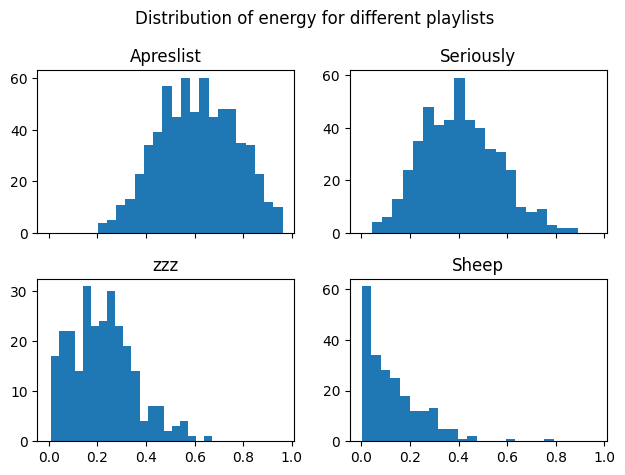

In [12]:
energy_dim = features.index("energy")

n_bins = 20
fig, axs = plt.subplots(2, 2, tight_layout=True, sharex=True)
axs[0][0].hist(apreslist_M[:,energy_dim], bins=n_bins)
axs[0][0].set_title("Apreslist")
axs[0][1].hist(seriously_M[:,energy_dim], bins=n_bins)
axs[0][1].set_title("Seriously")
axs[1][0].hist(zzz_M[:,energy_dim], bins=n_bins)
axs[1][0].set_title("zzz")
axs[1][1].hist(sheep_M[:,energy_dim], bins=n_bins)
axs[1][1].set_title("Sheep")
fig.suptitle("Distribution of energy for different playlists")
plt.show()

From first glance it seems that the distribution of energy in both Apreslist and Seriously is Gaussian. It's also good to see that there is a clear distinction between where the center of the distribution lies for the two playlists, about 0.6 for Apreslist and 0.4 for Seriously. zzz seems like a bimodal with one peak around 0.1 and another around 0.3. For sheep the distribution is a bit different, maybe a log-normal or chi-squared. This may need some playing around with, fitting different models and selecting the one with the highest (log) likelihood. 

The simplest solution would be to consider each distribution as a univariate normal so we'll start with that. This makes it very easy to fit the parameters by maximum likelihood.

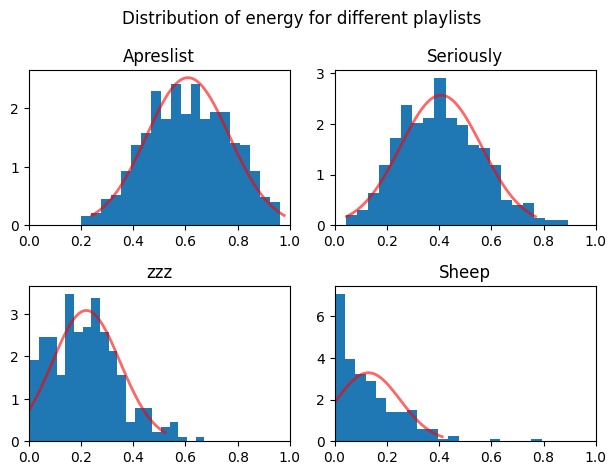

In [13]:
from scipy.stats import norm
from numpy.typing import NDArray


def fit_univariate_normal(data: NDArray):
    loc = np.mean(data)
    scale = np.std(data)
    return norm(loc, scale)


def plot_hist_and_dist(ax, data: NDArray, dist, nbins: int = 20) -> None:
    ax.hist(data, bins=nbins, density=True)
    x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
    ax.plot(x, dist.pdf(x), "r-", lw=2, alpha=0.6, label="pdf")
    ax.set_xlim([0, 1])


n_bins = 20
fig, axs = plt.subplots(2, 2, tight_layout=True)
dist_1 = fit_univariate_normal(apreslist_M[:, energy_dim])
plot_hist_and_dist(axs[0][0], apreslist_M[:, energy_dim], dist_1)
axs[0][0].set_title("Apreslist")
dist_2 = fit_univariate_normal(seriously_M[:, energy_dim])
plot_hist_and_dist(axs[0][1], seriously_M[:, energy_dim], dist_2)
axs[0][1].set_title("Seriously")
dist_3 = fit_univariate_normal(zzz_M[:, energy_dim])
plot_hist_and_dist(axs[1][0], zzz_M[:, energy_dim], dist_3)
axs[1][0].set_title("zzz")
dist_4 = fit_univariate_normal(sheep_M[:, energy_dim])
plot_hist_and_dist(axs[1][1], sheep_M[:, energy_dim], dist_4)
axs[1][1].set_title("Sheep")
fig.suptitle("Distribution of energy for different playlists")
plt.show()

In [15]:
norm_ll = (
    np.sum(dist_1.logpdf(apreslist_M[:, energy_dim]))
    + np.sum(dist_2.logpdf(seriously_M[:, energy_dim]))
    + np.sum(dist_3.logpdf(zzz_M[:, energy_dim]))
    + np.sum(dist_4.logpdf(sheep_M[:, energy_dim]))
)
print(f"total log likelihood for normal distribution: {norm_ll:.2f}")

total log likelihood for normal distribution: 806.09


The fit looks decent for the first three playlists but is pretty poor for Sheep. This is likely due to the fact that the values for energy are bounded in $[0, 1]$ but that isn't taken into account when calculating the data mean and standard deviation, the parameters of the normal distribution. To make use of this constraint, we can try fitting a truncated normal (which can be constrained to a certain boundary) or beta distribution (which has a support of $(0,1)$). We'll try a beta distribution first.

The beta distribution has two paramaters, $\alpha$ and $\beta$. These can be fit using `scipy`'s  `scipy.stats.rv_continuous.fit` method or can fit using manual optimization methods. We'll try both and see which one gives the best results.

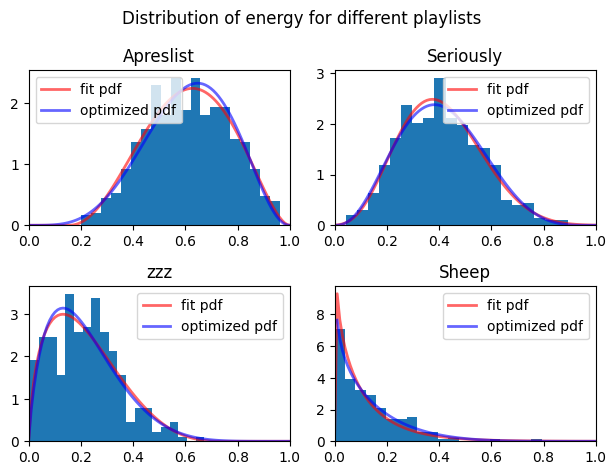

In [18]:
from scipy.stats import beta
from scipy.optimize import minimize

def fit_beta(data: NDArray):
    params = beta.fit(data)
    return beta(*params)


def fit_beta_optimized(data: NDArray):
    def func(p: tuple, r: NDArray) -> float:
        return -np.sum(beta.logpdf(r,*p))

    params = minimize(
        func,
        x0=(1,1),
        args=(data),
        bounds=((0, None), (0, None)),
    )

    return beta(*params.x)


def plot_hist_and_beta_dists(
    ax,
    data: NDArray,
    dist_fit,
    dist_optim,
    nbins: int = 20,
) -> None:
    ax.hist(data, bins=nbins, density=True)
    x = np.linspace(0, 1, 100)
    ax.plot(x, dist_fit.pdf(x), "r-", lw=2, alpha=0.6, label="fit pdf")
    ax.plot(x, dist_optim.pdf(x), "b-", lw=2, alpha=0.6, label="optimized pdf")
    ax.set_xlim([0, 1])
    ax.legend()


n_bins = 20
fig, axs = plt.subplots(2, 2, tight_layout=True)
dist_1_b = fit_beta(apreslist_M[:, energy_dim])
dist_1_o = fit_beta_optimized(apreslist_M[:, energy_dim])
plot_hist_and_beta_dists(axs[0][0], apreslist_M[:, energy_dim], dist_1_b, dist_1_o)
axs[0][0].set_title("Apreslist")
dist_2_b = fit_beta(seriously_M[:, energy_dim])
dist_2_o = fit_beta_optimized(seriously_M[:, energy_dim])
plot_hist_and_beta_dists(axs[0][1], seriously_M[:, energy_dim], dist_2_b, dist_2_o)
axs[0][1].set_title("Seriously")
dist_3_b = fit_beta(zzz_M[:, energy_dim])
dist_3_o = fit_beta_optimized(zzz_M[:, energy_dim])
plot_hist_and_beta_dists(axs[1][0], zzz_M[:, energy_dim], dist_3_b, dist_3_o)
axs[1][0].set_title("zzz")
dist_4_b = fit_beta(sheep_M[:, energy_dim])
dist_4_o = fit_beta_optimized(sheep_M[:, energy_dim])
plot_hist_and_beta_dists(axs[1][1], sheep_M[:, energy_dim], dist_4_b, dist_4_o)
axs[1][1].set_title("Sheep")
fig.suptitle("Distribution of energy for different playlists")
plt.show()

Both routines have returned good looking fitted parameters. We can verify which is best looking at the combined log likelihood across all playlists.

In [19]:
norm_ll = (
    np.sum(dist_1_b.logpdf(apreslist_M[:, energy_dim]))
    + np.sum(dist_2_b.logpdf(seriously_M[:, energy_dim]))
    + np.sum(dist_3_b.logpdf(zzz_M[:, energy_dim]))
    + np.sum(dist_4_b.logpdf(sheep_M[:, energy_dim]))
)
print(f"combined log likelihood for beta distribution with standard fitting: {norm_ll:.2f}")

norm_ll = (
    np.sum(dist_1_o.logpdf(apreslist_M[:, energy_dim]))
    + np.sum(dist_2_o.logpdf(seriously_M[:, energy_dim]))
    + np.sum(dist_3_o.logpdf(zzz_M[:, energy_dim]))
    + np.sum(dist_4_o.logpdf(sheep_M[:, energy_dim]))
)
print(f"combined log likelihood for beta distribution with optimized fitting: {norm_ll:.2f}")

combined log likelihood for beta distribution with standard fitting: 929.30
combined log likelihood for beta distribution with optimized fitting: 915.67


Standard fitting returns a better fit so we'll discard the optimized fitting routine which makes life easier anyway since standard fitting doesn't require any custom routines to be implemented. Note that both routines return a better fit compared to the combined normal distributions calculated earlier. It's possible however that the optimum combined log likelihood can be achieved by a combination of normal and beta distributions so it's best we look at the log likelihood for each individual playlists and select whichever one is a better fit. Judging from the plots, we can safely assume that the Sheep playlist is better suited to a beta distribution.

In [20]:
print("Apreslist")
print(f"Normal: {np.sum(dist_1.logpdf(apreslist_M[:, energy_dim])):.2f}")
print(f"Beta standard fit: {np.sum(dist_1_b.logpdf(apreslist_M[:, energy_dim])):.2f}")
print(f"Beta optimized fit: {np.sum(dist_1_o.logpdf(apreslist_M[:, energy_dim])):.2f}\n")

print("Seriously")
print(f"Normal: {np.sum(dist_2.logpdf(seriously_M[:, energy_dim])):.2f}")
print(f"Beta standard fit: {np.sum(dist_2_b.logpdf(seriously_M[:, energy_dim])):.2f}")
print(f"Beta optimized fit: {np.sum(dist_2_o.logpdf(seriously_M[:, energy_dim])):.2f}\n")

print("zzz")
print(f"Normal: {np.sum(dist_3.logpdf(zzz_M[:, energy_dim])):.2f}")
print(f"Beta standard fit: {np.sum(dist_3_b.logpdf(zzz_M[:, energy_dim])):.2f}")
print(f"Beta optimized fit: {np.sum(dist_3_o.logpdf(zzz_M[:, energy_dim])):.2f}\n")

print("sheep")
print(f"Normal: {np.sum(dist_4.logpdf(sheep_M[:, energy_dim])):.2f}")
print(f"Beta standard fit: {np.sum(dist_4_b.logpdf(sheep_M[:, energy_dim])):.2f}")
print(f"Beta optimized fit: {np.sum(dist_4_o.logpdf(sheep_M[:, energy_dim])):.2f}\n")

Apreslist
Normal: 277.10
Beta standard fit: 289.86
Beta optimized fit: 285.07

Seriously
Normal: 211.28
Beta standard fit: 218.43
Beta optimized fit: 216.80

zzz
Normal: 167.49
Beta standard fit: 185.26
Beta optimized fit: 183.95

sheep
Normal: 150.22
Beta standard fit: 235.74
Beta optimized fit: 229.86

